In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import joblib
import base64
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from IPython.display import display, clear_output, HTML, Image
import ipywidgets as widgets
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score,
                            confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

# Constants and paths
GDRIVE_BASE = "/content/drive/MyDrive"
FEEDBACK_FILE_PATH = os.path.join(GDRIVE_BASE, "user_feedback.csv")
KAGGLE_PATH = os.path.join(GDRIVE_BASE, "kaggle", "kaggle.json")
DATA_DIR = "fashion_dataset"
RESULTS_PER_PAGE = 5
MODEL_PATH = os.path.join(GDRIVE_BASE, "wardrobe_recommender_model.pkl")

# Mount Google Drive
drive.mount('/content/drive')

# Initialize global variables
feedback_data = {'outfits': {}, 'items': {}}
previous_outfits = set()
filtered_results = None
selected_item_id = None
recommendations = None
current_index = 0
current_index_recommendations = 0
feedback_data = {'outfits': {}, 'items': {}}
feedback_data['item_feedback'] = {}


# Enhanced Wardrobe Recommender Class
class WardrobeRecommender:
    def __init__(self):
        self.model = None
        self.feature_encoder = None
        self.feedback_count = 0
        self.load_or_train_model()

    def load_or_train_model(self):
        try:
            if os.path.exists(MODEL_PATH):
                self.model, self.feature_encoder = joblib.load(MODEL_PATH)
                print("✅ Loaded pre-trained model")
                if os.path.exists(FEEDBACK_FILE_PATH):
                    with open(FEEDBACK_FILE_PATH) as f:
                        self.feedback_count = sum(1 for _ in f) - 1
            else:
                self.train_model()
        except Exception as e:
            print(f"Error loading model: {e}")
            self.train_model()

    def prepare_features(self, feedback_df):
        if len(feedback_df) == 0:
            return None, None
        X = feedback_df[['gender', 'articleType', 'baseColour', 'season', 'usage']].copy()
        X['color_season'] = X['baseColour'] + "_" + X['season']
        X['type_usage'] = X['articleType'] + "_" + X['usage']
        X['color_type'] = X['baseColour'] + "_" + X['articleType']
        X['season_usage'] = X['season'] + "_" + X['usage']
        y = feedback_df['label']
        return X, y

    def train_model(self):
        try:
            feedback_df = pd.read_csv(FEEDBACK_FILE_PATH)
            X, y = self.prepare_features(feedback_df)

            if X is None or len(X) < 10:
                print("⚠️ Not enough feedback data - using default model")
                self.create_default_model()
                return

            class_counts = y.value_counts()
            if min(class_counts) < 5:
                print("⚠️ Not enough balanced feedback data - using existing model")
                return

            categorical_features = ['gender', 'articleType', 'baseColour', 'season', 'usage',
                                'color_season', 'type_usage', 'color_type', 'season_usage']

            preprocessor = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
                ])

            # Dynamic class weighting
            dislike_count = sum(y == 0)
            like_count = sum(y == 1)
            class_weight = {0: max(3, like_count/dislike_count if dislike_count >0 else 3), 1: 1}

            self.model = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(
                    n_estimators=100,
                    class_weight=class_weight,
                    random_state=42,
                    min_samples_leaf=5
                ))
            ])

            self.model.fit(X, y)
            self.feature_encoder = self.model.named_steps['preprocessor']
            joblib.dump((self.model, self.feature_encoder), MODEL_PATH)
            print("✅ Trained and saved new model with enhanced dislike handling")
            self.feedback_count = len(feedback_df)
        except Exception as e:
            print(f"Error training model: {e}")
            self.create_default_model()

    def create_default_model(self):
        self.model = None
        self.feature_encoder = None

    def predict_preference(self, item_features):
        if self.model is None:
            return 0.5

        try:
            input_df = pd.DataFrame([{
                'gender': item_features['gender'],
                'articleType': item_features['articleType'],
                'baseColour': item_features['baseColour'],
                'season': item_features['season'],
                'usage': item_features['usage'],
                'color_season': item_features['baseColour'] + "_" + item_features['season'],
                'type_usage': item_features['articleType'] + "_" + item_features['usage'],
                'color_type': item_features['baseColour'] + "_" + item_features['articleType'],
                'season_usage': item_features['season'] + "_" + item_features['usage']
            }])

            base_score = self.model.predict_proba(input_df)[0][1]
            item_id_tuple = tuple(item_features.values())
            dislike_count = feedback_data['item_feedback'].get(item_id_tuple, {}).get('dislikes', 0)

            # Apply exponential decay for disliked items
            return base_score * (0.85 ** dislike_count)
        except Exception as e:
            print(f"Prediction error: {e}")
            return 0.5

# Initialize recommender
recommender = WardrobeRecommender()


def load_feedback_aggregates():
    global feedback_data, feedback_df
    feedback_df = pd.read_csv(FEEDBACK_FILE_PATH)
    feedback_data['item_feedback'] = {}

    for _, row in feedback_df.iterrows():
        item_id = (row['gender'], row['articleType'], row['baseColour'], row['season'], row['usage'])
        if item_id not in feedback_data['item_feedback']:
            feedback_data['item_feedback'][item_id] = {'likes': 0, 'dislikes': 0}
        if row['label'] == 1:
            feedback_data['item_feedback'][item_id]['likes'] += 1
        else:
            feedback_data['item_feedback'][item_id]['dislikes'] += 1


def create_feedback_file():
    if not os.path.exists(FEEDBACK_FILE_PATH):
        feedback_df = pd.DataFrame(columns=['gender', 'articleType', 'baseColour', 'season', 'usage', 'label'])
        feedback_df.to_csv(FEEDBACK_FILE_PATH, index=False)
        print(f"✅ Created empty 'user_feedback.csv' at {FEEDBACK_FILE_PATH}")

create_feedback_file()
feedback_df = pd.read_csv(FEEDBACK_FILE_PATH)
load_feedback_aggregates()


def setup_kaggle_api():
    os.makedirs("/root/.kaggle", exist_ok=True)
    if os.path.exists(KAGGLE_PATH):
        os.system(f"cp {KAGGLE_PATH} /root/.kaggle/kaggle.json")
        os.chmod("/root/.kaggle/kaggle.json", 600)
    else:
        raise FileNotFoundError("❌ Please place kaggle.json in /MyDrive/kaggle/")

def download_dataset():
    if not os.path.exists(DATA_DIR):
        !kaggle datasets download -d paramaggarwal/fashion-product-images-small
        with zipfile.ZipFile("fashion-product-images-small.zip", "r") as zip_ref:
            zip_ref.extractall(DATA_DIR)
    else:
        print("✅ Dataset already available.")


def load_and_clean_data():
    csv_path = os.path.join(DATA_DIR, "styles.csv")
    df = pd.read_csv(csv_path, on_bad_lines='skip')
    df.dropna(subset=['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
                     'baseColour', 'season', 'usage'], inplace=True)

    df = df[df['gender'].isin(['Men', 'Women'])]
    df = df[df['masterCategory'] == 'Apparel']
    df = df[df['subCategory'].isin(['Topwear', 'Bottomwear', 'Dress', 'Apparel Set'])]
    df = df[df['articleType'].isin(['Shirts', 'Jeans', 'Tshirts', 'Sweatshirts',
                                   'Dresses', 'Clothing Set', 'Skirts', 'Tops'])]
    df = df[df['baseColour'].isin(['Blue', 'Black', 'Green', 'White', 'Pink', 'Red', 'Coffee Brown'])]
    df = df[df['season'].isin(['Fall', 'Summer', 'Winter', 'Spring'])]
    df = df[df['usage'].isin(['Casual', 'Ethnic', 'Formal', 'Sports', 'Smart Casual', 'Travel', 'Party', 'Home'])]
    df.reset_index(drop=True, inplace=True)

    tops = ['Shirts', 'Tshirts', 'Sweatshirts', 'Tops']
    bottoms = ['Jeans', 'Skirts']
    df['category'] = df['articleType'].apply(lambda x: 'top' if x in tops else 'bottom' if x in bottoms else 'other')

    return df

setup_kaggle_api()
download_dataset()
df = load_and_clean_data()

# Widget setup
gender_widget = widgets.Dropdown(options=['', 'Men', 'Women'], description='Gender:')
article_widget = widgets.Dropdown(options=[''] + sorted(df['articleType'].unique()), description='Article:')
color_widget = widgets.Dropdown(options=[''] + sorted(df['baseColour'].unique()), description='Color:')
season_widget = widgets.Dropdown(options=['', 'Fall', 'Summer', 'Winter', 'Spring'], description='Season:')
usage_widget = widgets.Dropdown(options=['', 'Casual', 'Ethnic', 'Formal', 'Sports', 'Smart Casual', 'Travel', 'Party', 'Home'], description='Usage:')
export_button = widgets.Button(description="⬇️ Export Filtered")
filter_button = widgets.Button(description="🔍 Show Outfits")
recommend_button = widgets.Button(description="Recommend Outfit")
show_more_button = widgets.Button(description="Show More 👗", button_style='success')
show_less_button = widgets.Button(description="Show Less 👈", button_style='warning')
full_set_button = widgets.Button(description="Full Set")

def save_feedback(row, label, immediate_update=False):
    global feedback_df, feedback_data

    item_id = tuple([row['gender'], row['articleType'], row['baseColour'],
                     row['season'], row['usage']])

    # Initialize feedback tracking
    if 'item_feedback' not in feedback_data:
        feedback_data['item_feedback'] = {}

    if item_id not in feedback_data['item_feedback']:
        feedback_data['item_feedback'][item_id] = {'likes': 0, 'dislikes': 0}

    # Update counts
    if label == 1:
        feedback_data['item_feedback'][item_id]['likes'] += 1
    else:
        feedback_data['item_feedback'][item_id]['dislikes'] += 1

    # Exponential severity scaling with decay
    current_dislikes = feedback_data['item_feedback'][item_id]['dislikes']
    decay_factor = max(0.7, 1 - (current_dislikes * 0.05))
    severity = (1 + (current_dislikes ** 1.5) * 0.8) * decay_factor

    # Create feedback entries
    feedback_entries = []
    for _ in range(int(severity)):
        feedback_entries.append({
            'gender': row['gender'],
            'articleType': row['articleType'],
            'baseColour': row['baseColour'],
            'season': row['season'],
            'usage': row['usage'],
            'label': label
        })

    # Update data structures
    feedback_df = pd.concat([feedback_df, pd.DataFrame(feedback_entries)], ignore_index=True)
    feedback_df.to_csv(FEEDBACK_FILE_PATH, index=False)

    # Retraining conditions
    if label == 0 or (label == 1 and feedback_data['item_feedback'][item_id]['likes'] % 2 == 0):
        recommender.train_model()

    print(f"✅ Feedback saved (severity: {severity:.1f}x)")

def filter_outfits(data, preferences):
    filtered_data = data.copy()

    for key, val in preferences.items():
        if val:
            filtered_data = filtered_data[filtered_data[key] == val]

    if len(filtered_data) > 0:
        filtered_data['preference_score'] = filtered_data.apply(
            lambda row: recommender.predict_preference({
                'gender': row['gender'],
                'articleType': row['articleType'],
                'baseColour': row['baseColour'],
                'season': row['season'],
                'usage': row['usage']
            }), axis=1)

        filtered_data = filtered_data.sort_values(
            by='preference_score',
            ascending=False
        ).reset_index(drop=True)
    else:
        filtered_data = filtered_data.sort_values(by='id')

    return filtered_data

def create_display_box(row):
    img_file = os.path.join(DATA_DIR, "images", str(row['id']) + '.jpg')
    if os.path.exists(img_file):
        try:
            with open(img_file, "rb") as f:
                image_data = f.read()
            img_base64 = f"data:image/jpeg;base64,{base64.b64encode(image_data).decode()}"
            img_tag = f"<img src='{img_base64}' width='120' height='160' style='object-fit:cover;border-radius:10px;'>"
        except:
            img_tag = "<div style='width:120px;height:160px;background:#eee;text-align:center;'>Load Error</div>"
    else:
        img_tag = "<div style='width:120px;height:160px;background:#eee;text-align:center;'>No Image</div>"

    select_button = widgets.Button(description="✓", layout=widgets.Layout(width="40px"))
    like_button = widgets.Button(description="👍", layout=widgets.Layout(width="40px"))
    dislike_button = widgets.Button(description="👎", layout=widgets.Layout(width="40px"))

    # Get feedback counts
    item_id = tuple([row['gender'], row['articleType'], row['baseColour'],
                     row['season'], row['usage']])
    item_feedback = feedback_data.get('item_feedback', {})
    dislikes = item_feedback.get(item_id, {}).get('dislikes', 0)
    likes = item_feedback.get(item_id, {}).get('likes', 0)

    def on_select(b):
        global selected_item_id, recommendations
        selected_item_id = row['id']
        recommendations = None
        recommendations = recommend_matches(df[df['id'] == selected_item_id].iloc[0])
        print(f"Selected item ID: {selected_item_id}")

    def on_like(b):
        save_feedback(row, 1, immediate_update=True)
        global recommendations
        recommendations = None
        clear_output(wait=True)
        display_widgets()
        display_next_batch()

    def on_dislike(b):
        save_feedback(row, 0, immediate_update=True)
        global recommendations
        recommendations = None
        clear_output(wait=True)
        display_widgets()
        display_next_batch()

    select_button.on_click(on_select)
    like_button.on_click(on_like)
    dislike_button.on_click(on_dislike)

    button_box = widgets.HBox([select_button, like_button, dislike_button])

    # Add feedback indicators
    display_html = f"""
    <div style='text-align:center'>
        {img_tag}<br>
        <b>{row['articleType']}</b><br>
        <span style='color:gray;font-size:smaller'>
            {row['baseColour']} | {row['season']} | {row['usage']}
        </span>
        <div style='font-size:smaller;color:{"green" if likes > dislikes else "red"}'>
            👍{likes} | 👎{dislikes}
        </div>
    </div>
    """

    display_box = widgets.VBox([
        widgets.HTML(value=display_html),
        button_box
    ])
    return display_box

def display_grid(items, current_index=0):
    global show_more_button, show_less_button

    end_index = min(current_index + RESULTS_PER_PAGE, len(items))
    html = "<table style='width:100%'><tr>"
    count = 0
    for idx, row in items.iloc[current_index:end_index].iterrows():
        display_box = create_display_box(row)
        html += "<td style='padding:10px;vertical-align:top;'>"
        display(display_box)
        html += "</td>"

        count += 1
        if count % 3 == 0:
            html += "</tr><tr>"
    html += "</tr></table>"
    display(HTML(html))

    show_more_button.layout.visibility = 'visible' if end_index < len(items) else 'hidden'
    show_less_button.layout.visibility = 'visible' if current_index > 0 else 'hidden'
    display(show_more_button)
    display(show_less_button)

def display_next_batch(b=None):
    global current_index, current_index_recommendations, filtered_results, recommendations
    clear_output(wait=True)
    display_widgets()
    if filtered_results is not None:
        current_index += RESULTS_PER_PAGE
        display_grid(filtered_results, current_index)
    elif recommendations is not None:
        current_index_recommendations += RESULTS_PER_PAGE
        display_recommendations(recommendations, current_index_recommendations)

def display_previous_batch(b=None):
    global current_index, current_index_recommendations, filtered_results, recommendations
    clear_output(wait=True)
    display_widgets()
    if filtered_results is not None:
        current_index = max(0, current_index - RESULTS_PER_PAGE)
        display_grid(filtered_results, current_index)
    elif recommendations is not None:
        current_index_recommendations = max(0, current_index_recommendations - RESULTS_PER_PAGE)
        display_recommendations(recommendations, current_index_recommendations)

def on_filter_clicked(b):
    global current_index, filtered_results, recommendations
    recommendations = None
    current_index = 0
    preferences = {
        'gender': gender_widget.value,
        'articleType': article_widget.value,
        'baseColour': color_widget.value,
        'season': season_widget.value,
        'usage': usage_widget.value
    }

    filtered_results = filter_outfits(df, preferences)
    clear_output(wait=True)
    display_widgets()
    display_grid(filtered_results, current_index)
    print(f"Number of items after filtering: {len(filtered_results)}")

def on_recommend_clicked(b):
    global selected_item_id, current_index_recommendations, recommendations, filtered_results
    filtered_results = None
    current_index_recommendations = 0
    if selected_item_id is not None:
        selected_item_row = df[df['id'] == selected_item_id].iloc[0]
        recommendations = recommend_matches(selected_item_row)
        clear_output(wait=True)
        display_widgets()
        display_recommendations(recommendations, current_index_recommendations)
    else:
        print("Please select an item first.")

def on_export_clicked(b):
    if filtered_results is not None and len(filtered_results) > 0:
        filtered_results.to_csv("filtered_results.csv", index=False)
        filtered_results.to_json("filtered_results.json", orient="records")
        print("✅ Exported to `filtered_results.csv` and `filtered_results.json`")
    else:
        print("⚠️ Nothing to export. Try filtering first.")

compatible_color_pairs = [
    ('Blue', 'White'), ('Black', 'White'), ('Green', 'Black'),
    ('White', 'Blue'), ('White', 'Black'), ('Black', 'Green'),
    ('Pink', 'White'), ('Pink', 'Black'), ('Pink', 'Blue'),
    ('White', 'Pink'), ('Black', 'Pink'), ('Blue', 'Pink'),
    ('Red', 'White'), ('Red', 'Black'), ('Red', 'Blue'),
    ('White', 'Red'), ('Black', 'Red'), ('Blue', 'Red'),
    ('Coffee Brown', 'White'), ('Coffee Brown', 'Black'), ('Coffee Brown', 'Blue'),
    ('White', 'Coffee Brown'), ('Black', 'Coffee Brown'), ('Blue', 'Coffee Brown'),
    ('Green', 'White'), ('Green', 'Pink'), ('Green', 'Red'),
    ('White', 'Green'), ('Pink', 'Green'), ('Red', 'Green'),
    ('Blue', 'Black'), ('Blue', 'Pink'), ('Blue', 'Red'),
    ('Black', 'Blue'), ('Pink', 'Blue'), ('Red', 'Blue'),
    ('Black', 'Pink'), ('Black', 'Red'),
    ('Pink', 'Black'), ('Red', 'Black'),
    ('Pink', 'Red'), ('Red', 'Pink'),
    ('Coffee Brown', 'Pink'), ('Coffee Brown', 'Red'), ('Coffee Brown', 'Green'),
    ('Pink', 'Coffee Brown'), ('Red', 'Coffee Brown'), ('Green', 'Coffee Brown')
]

compatible_style_pairs = [
    ('Casual', 'Casual'), ('Ethnic', 'Ethnic'), ('Formal', 'Formal'),
    ('Sports', 'Sports'), ('Smart Casual', 'Smart Casual'), ('Travel', 'Travel'),
    ('Party', 'Party'), ('Home', 'Home'),
    ('Casual', 'Smart Casual'), ('Smart Casual', 'Casual'),
    ('Casual', 'Travel'), ('Travel', 'Casual'),
    ('Casual', 'Home'), ('Home', 'Casual'),
    ('Ethnic', 'Party'), ('Party', 'Ethnic'),
    ('Formal', 'Smart Casual'), ('Smart Casual', 'Formal'),
    ('Formal', 'Party'), ('Party', 'Formal'),
    ('Sports', 'Casual'), ('Casual', 'Sports'),
    ('Sports', 'Travel'), ('Travel', 'Sports')
]

def score_outfit(top_row, bottom_row):
    score = 0
    if top_row['gender'] != bottom_row['gender'] or top_row['season'] != bottom_row['season']:
        return score

    score += 2

    top_color = top_row['baseColour']
    bottom_color = bottom_row['baseColour']

    if top_color == bottom_color:
        score += 1
    elif (top_color, bottom_color) in compatible_color_pairs:
        score += 0.5

    top_style = top_row['usage']
    bottom_style = bottom_row['usage']

    if top_style == bottom_style:
        score += 0.25
    elif (top_style, bottom_style) in compatible_style_pairs:
        score += 0.125

    return score

def recommend_matches(item_row, num_recommendations=5):
    item_category = item_row['category']
    target_category = 'bottom' if item_category == 'top' else 'top' if item_category == 'bottom' else None

    if target_category:
        matches = df[df['category'] == target_category].copy()

        # Calculate compatibility scores
        matches['compatibility_score'] = matches.apply(
            lambda row: score_outfit(item_row, row), axis=1)
        matches = matches[matches['compatibility_score'] > 0]

        if len(matches) == 0:
            return None

        # Filter out disliked items
        if 'item_feedback' in feedback_data:
            disliked_items = {
                item_id for item_id, counts in feedback_data['item_feedback'].items()
                if counts['dislikes'] > counts['likes']  # More dislikes than likes
            }

            matches = matches[~matches.apply(
                lambda row: (row['gender'], row['articleType'], row['baseColour'],
                            row['season'], row['usage']) in disliked_items, axis=1)]

        # Add preference predictions
        matches['preference_score'] = matches.apply(
            lambda row: recommender.predict_preference({
                'gender': row['gender'],
                'articleType': row['articleType'],
                'baseColour': row['baseColour'],
                'season': row['season'],
                'usage': row['usage']
            }), axis=1)

        # Dynamic weighting - give more weight to preferences when we have more feedback
        feedback_weight = min(0.8, len(feedback_df)/100)
        compatibility_weight = 1 - feedback_weight

        matches['combined_score'] = (
            compatibility_weight * matches['compatibility_score'] +
            feedback_weight * matches['preference_score']
        )

        return matches.sort_values('combined_score', ascending=False).head(num_recommendations)
    return None

def generate_outfit(item_row, previous_outfits=None):
    item_category = item_row['category']
    target_category = 'bottom' if item_category == 'top' else 'top' if item_category == 'bottom' else None

    if target_category:
        matches = df[df['category'] == target_category].copy()
        matches['score'] = matches.apply(lambda row: score_outfit(item_row, row), axis=1)

        if previous_outfits is not None:
            matches = matches[~matches['id'].isin(previous_outfits)]

        matches = matches[matches['score'] > 0].sort_values(by=['score'], ascending=False)

        if len(matches) > 0:
            best_match = matches.iloc[0]
            return [item_row, best_match]

    return None

def display_outfit(outfit):
    html = "<table style='width:100%'><tr>"
    for item_row in outfit:
        display_box = create_display_box(item_row)
        html += "<td style='padding:10px;vertical-align:top;'>"
        display(display_box)
        html += "</td>"
    html += "</tr></table>"
    display(HTML(html))

    like_button = widgets.Button(description="👍 Like Outfit", button_style='success')
    dislike_button = widgets.Button(description="👎 Dislike Outfit", button_style='danger')

    def on_like(b):
        for item in outfit:
            save_feedback(item, 1, immediate_update=True)
        print("✅ You liked the outfit! Feedback saved.")

    def on_dislike(b):
        for item in outfit:
            save_feedback(item, 0, immediate_update=True)
        clear_output(wait=True)
        display_widgets()

        global selected_item_id
        if b.description == "👎 Dislike Outfit":
            selected_item_row = df[df['id'] == selected_item_id].iloc[0]

            for item in outfit:
                previous_outfits.add(item['id'])

            new_outfit = generate_outfit(selected_item_row, previous_outfits)

            if new_outfit:
                display_outfit(new_outfit)
            else:
                print("No more suitable outfits found for this item.")

    like_button.on_click(on_like)
    dislike_button.on_click(on_dislike)

    display(widgets.HBox([like_button, dislike_button]))

def on_full_set_clicked(b):
    global selected_item_id
    if selected_item_id is not None:
        selected_item_row = df[df['id'] == selected_item_id].iloc[0]
        outfit = generate_outfit(selected_item_row)
        if outfit:
            clear_output(wait=True)
            display_widgets()
            display_outfit(outfit)
        else:
            print("No suitable outfit found for this item.")
    else:
        print("Please select an item first.")

def display_recommendations(recommendations, current_index_recommendations=0):
    global show_more_button, show_less_button

    if recommendations is not None:
        end_index = min(current_index_recommendations + RESULTS_PER_PAGE, len(recommendations))
        display_recommendations_batch(recommendations.iloc[current_index_recommendations:end_index])

        show_more_button.layout.visibility = 'visible' if end_index < len(recommendations) else 'hidden'
        show_less_button.layout.visibility = 'visible' if current_index_recommendations > 0 else 'hidden'
        display(show_more_button)
        display(show_less_button)
    else:
        print("No recommendations found for this item.")

def display_recommendations_batch(recommendations_batch):
    html = "<table style='width:100%'><tr>"
    count = 0
    for idx, row in recommendations_batch.iterrows():
        display_box = create_display_box(row)
        html += "<td style='padding:10px;vertical-align:top;'>"
        display(display_box)
        html += "</td>"

        count += 1
        if count % 3 == 0:
            html += "</tr><tr>"
    html += "</tr></table>"
    display(HTML(html))

def display_widgets():
    display(gender_widget, article_widget, color_widget, season_widget,
            usage_widget, filter_button, export_button, recommend_button, full_set_button)

# Connect button events
filter_button.on_click(on_filter_clicked)
export_button.on_click(on_export_clicked)
recommend_button.on_click(on_recommend_clicked)
show_more_button.on_click(display_next_batch)
show_less_button.on_click(display_previous_batch)
full_set_button.on_click(on_full_set_clicked)

# Initialize and display the interface
display_widgets()

Mounted at /content/drive
✅ Loaded pre-trained model
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT


Dropdown(description='Gender:', options=('', 'Men', 'Women'), value='')

Dropdown(description='Article:', options=('', 'Dresses', 'Jeans', 'Shirts', 'Skirts', 'Sweatshirts', 'Tops', '…

Dropdown(description='Color:', options=('', 'Black', 'Blue', 'Coffee Brown', 'Green', 'Pink', 'Red', 'White'),…

Dropdown(description='Season:', options=('', 'Fall', 'Summer', 'Winter', 'Spring'), value='')

Dropdown(description='Usage:', options=('', 'Casual', 'Ethnic', 'Formal', 'Sports', 'Smart Casual', 'Travel', …

Button(description='🔍 Show Outfits', style=ButtonStyle())

Button(description='⬇️ Export Filtered', style=ButtonStyle())

Button(description='Recommend Outfit', style=ButtonStyle())

Button(description='Full Set', style=ButtonStyle())


📊 Model Performance Evaluation 📊
--------------------------------
Accuracy:  0.81
Precision: 0.91
Recall:    0.84
F1-score:  0.88

Classification Report:
              precision    recall  f1-score   support

    Disliked       0.52      0.68      0.59        90
       Liked       0.91      0.84      0.88       361

    accuracy                           0.81       451
   macro avg       0.71      0.76      0.73       451
weighted avg       0.83      0.81      0.82       451



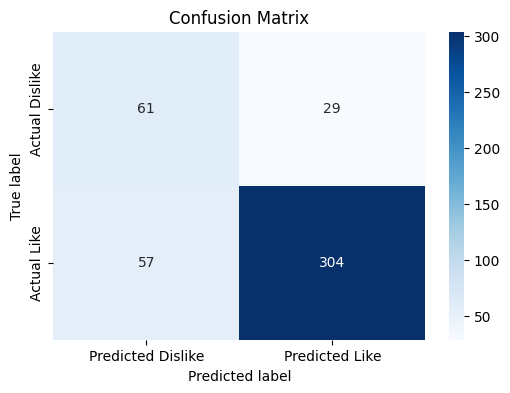

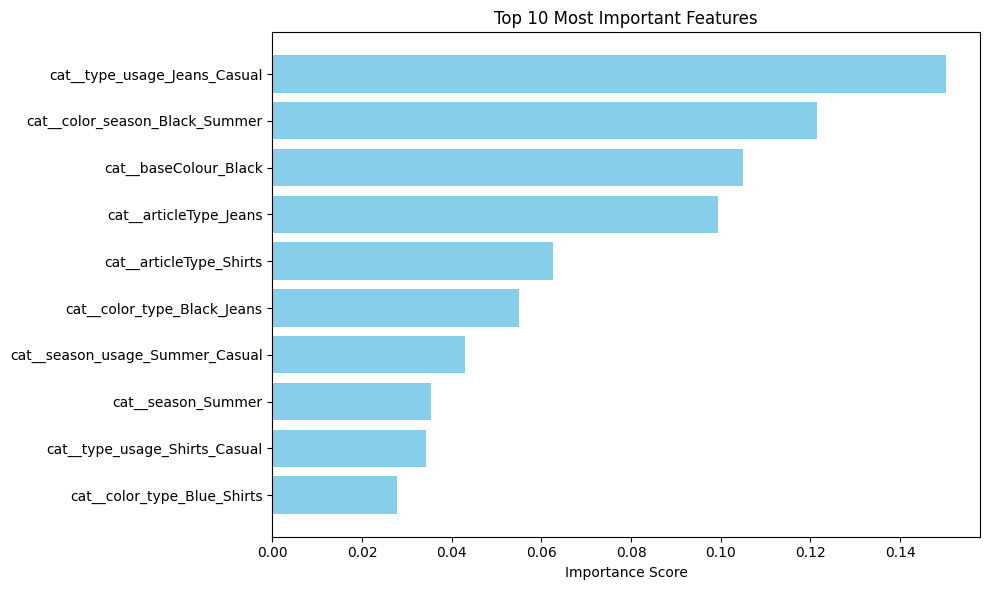

Mounted at /content/drive
✅ Plot saved to Google Drive at: /content/drive/MyDrive/feature_importance.png


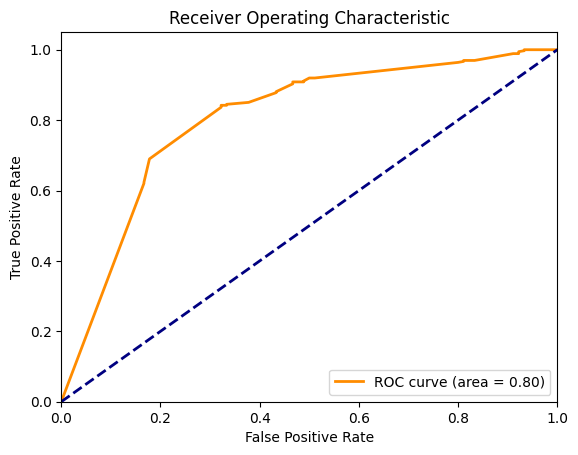

{'accuracy': 0.8093126385809313,
 'precision': 0.9129129129129129,
 'recall': 0.8421052631578947,
 'f1': 0.8760806916426513,
 'feature_importances':                             Feature  Importance
 39     cat__type_usage_Jeans_Casual    0.150322
 23   cat__color_season_Black_Summer    0.121452
 7             cat__baseColour_Black    0.105060
 3            cat__articleType_Jeans    0.099432
 4           cat__articleType_Shirts    0.062622
 ..                              ...         ...
 67       cat__color_type_White_Tops    0.000000
 66     cat__color_type_White_Skirts    0.000000
 77  cat__season_usage_Summer_Sports    0.000000
 79  cat__season_usage_Winter_Formal    0.000000
 80   cat__season_usage_Winter_Party    0.000000
 
 [81 rows x 2 columns]}

In [2]:
from sklearn.metrics import roc_curve, auc
import shutil

def evaluate_model_performance():
    # Load the feedback data
    feedback_df = pd.read_csv(FEEDBACK_FILE_PATH)

    # Prepare features and target
    X, y = recommender.prepare_features(feedback_df)

    if X is None or len(X) < 10:
        print("⚠️ Not enough data for evaluation (minimum 10 samples required)")
        return

    # Split data into train (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train a fresh model for evaluation
    temp_model = Pipeline([
        ('preprocessor', recommender.feature_encoder),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            min_samples_leaf=5
        ))
    ])

    temp_model.fit(X_train, y_train)

    # Make predictions
    y_pred = temp_model.predict(X_test)
    y_pred_proba = temp_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (like)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\n📊 Model Performance Evaluation 📊")
    print("--------------------------------")
    print(f"Accuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1-score:  {f1:.2f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Disliked', 'Liked']))

    # Confusion matrix visualization
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Dislike', 'Predicted Like'],
                yticklabels=['Actual Dislike', 'Actual Like'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Feature importance
    feature_importances = temp_model.named_steps['classifier'].feature_importances_
    encoded_features = temp_model.named_steps['preprocessor'].get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': encoded_features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # Feature importance visualization
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(10).sort_values('Importance', ascending=True)
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance Score')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()

    # Save to file
    importance_plot_path = '/content/feature_importance.png'
    plt.savefig(importance_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Upload to Google Drive
    drive.mount('/content/drive', force_remount=True)
    drive_plot_path = os.path.join(GDRIVE_BASE, 'feature_importance.png')
    shutil.copy(importance_plot_path, drive_plot_path)
    print(f"✅ Plot saved to Google Drive at: {drive_plot_path}")

    # ROC Curve
    plt.figure()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'feature_importances': importance_df
    }

evaluate_model_performance()